# Hierarchical sparse coding networks

\begin{equation}
    \begin{cases}
        \pmb{s}^{(n)}_{L-1} &= \pmb{W}_L \pmb{s}^{(n)}_L + \pmb{z}^{(n)}_L & \text{ s.t. }  & \lVert \pmb{s}^{(n)}_L \rVert_0 < \alpha_L \text{ and } \pmb{s}^{(n)}_L > 0  \\
        & \vdots \\ 
        \pmb{s}^{(n)}_{1} &= \pmb{W}_2 \pmb{s}^{(n)}_2 + \pmb{z}^{(n)}_2 & \text{ s.t. }  & \lVert \pmb{s}^{(n)}_2 \rVert_0 < \alpha_2 \text{ and } \pmb{s}^{(n)}_2 > 0  \\
        \pmb{y}^{(n)} &= \pmb{W}_1 \pmb{s}^{(n)}_1 + \pmb{z}^{(n)}_1 & \text{ s.t. }  & \lVert \pmb{s}^{(n)}_1 \rVert_0 < \alpha_1 \text{ and } \pmb{s}^{(n)}_1 > 0 
    \end{cases}
\end{equation}

# Bayesian sparse coding

\begin{equation}
 \begin{split}
    \pmb{u}^{(n)} & \sim Exp(\lambda) \\
    \pmb{s}^{(n)} &= ReLU(\pmb{u}^{(n)} - \gamma) \\
    \pmb{y}^{(n)} &= \pmb{W} \pmb{s}^{(n)} + \pmb{z}^{(n)}
 \end{split}
\end{equation}

or approximately 

\begin{equation}
 \begin{split}
    \pmb{v}^{(n)} & \sim \mathcal{N}\left(0, \mathbb{I} \right) \\
    \pmb{s}^{(n)} &= ReLU( f\left(\pmb{v}^{(n)}\right) - \gamma) \\
    \pmb{y}^{(n)} &= \pmb{W} \pmb{s}^{(n)} + \pmb{z}^{(n)}
 \end{split}
\end{equation}

where $f(x) = \ln \left( 1 + e^{-a \cdot x}  \right)$, and $a = 1.702$.

\begin{equation}
 \begin{split}
    \langle s_i^{(n)} \rangle &= e^{- \lambda \gamma} = \pi ^ \lambda \\
    Var\left( s_i^{(n)} \right) &= \pi^2 + 2 \frac{\pi^\lambda}{\lambda} \left( \frac{1}{\lambda} - \pi \right) = \rho ^ 2 \\
 \end{split}
\end{equation}



# Hierarchical Bayesian sparse coding

\begin{equation}
    \begin{cases}
        \pmb{v}^{(n)}_L & = \pmb{z}^{(n)}_L  \\
        \pmb{s}^{(n)}_L & = ReLU( f\left(\pmb{v}^{(n)}_L \right) - \gamma_L) - \pi_L^{\lambda_L} \\ 
        \pmb{v}^{(n)}_{L-1} &= \pmb{W}_L \pmb{s}^{(n)}_L + \pmb{z}^{(n)}_{L-1} \\
        & \vdots \\ 
        \pmb{v}^{(n)}_{1} &= \pmb{W}_2 \pmb{s}^{(n)}_2 + \pmb{z}^{(n)}_1 \\
        \sigma_{1i} &= \sqrt{ s_1^2 + \rho_L^2 \sum_j W_{ij}^2 } \\
        \pmb{s}^{(n)}_1 & = ReLU \left( f\left(\pmb{v}^{(n)}_1 / \pmb{\sigma}_1 \right) - \gamma_1 \right) - \pi_1^{\lambda_1} \\
        \pmb{y}^{(n)} &= \pmb{W}_1 \pmb{s}^{(n)}_1 + \pmb{z}^{(n)}_0 
    \end{cases}
\end{equation}

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

####################
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from functools import partial
from jax import random, vmap, nn
from jax.nn import one_hot
from flax import linen as fnn
from typing import Any, Callable, Sequence, Optional

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import handlers

sns.set(context='notebook')

rng_key = random.PRNGKey(3478)

In [3]:
from jax import jit, grad
from jax.scipy.special import erf

@jit
def f(x, a=1.702):
    z = nn.sigmoid(a * x)  # approx for 0.5 * ( 1 + erf(x/jnp.sqrt(2)))
    return - jnp.log(z)

jit_grad_f = jit(grad(f))
print(jit_grad_f(-0.))

%timeit jit_grad_f(-0.)

-0.851
72.1 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
def global_vars(d, k, m, l):
    
    gamma = numpyro.sample('gamma', dist.Gamma(1, 1).expand([l]))
    sig = numpyro.sample('sig', dist.Gamma(1/2, 1).expand([l, 2]).to_event(1))
    scale = numpyro.deterministic('scale', jnp.sqrt(sig[..., 0]/sig[..., 1]) )

    _lam = numpyro.sample('_lam', dist.Gamma(1/2, 1).expand([l, 2]).to_event(1))
    lam = numpyro.deterministic('lam', jnp.sqrt(_lam[..., 0]/_lam[..., 1]))
    
    _tau = numpyro.sample('_tau', dist.Gamma(1/2, 1).expand([l, 2, d]).to_event(2))
    tau = numpyro.deterministic('tau', jnp.sqrt(_tau[:, 0]/_tau[:, 1]))

    _W = numpyro.sample('_W_base', dist.Normal(0, 1).expand([l-1, d, d]).to_event(2))
    s = 1e-2 * jnp.expand_dims(lam, -1) * tau
    W = numpyro.deterministic('W', jnp.expand_dims(s[:-1], -1) * _W)


    _W = numpyro.sample('W1_base', dist.Normal(0, 1).expand([d, k, m]).to_event(2))
    W1 = numpyro.deterministic('W1', jnp.expand_dims(s[-1], (-1, -2)) * _W)

    return list(W) + [W1], scale, gamma

def local_vars(W, v, scale, gamma, l):
    shape = W.shape
    d = shape[0]

    # mean 
    pi = jnp.exp( - gamma)

    # standard deviation 
    rho_square = pi * (2 - pi)
    W = W.reshape(d, -1)
    std = jnp.sqrt(scale ** 2 + rho_square * jnp.square(W).sum(0))

    s = numpyro.deterministic(f's_{l}', nn.relu( f(v) - gamma ) )
    loc = numpyro.deterministic(f'loc_{l}', ((s - pi) @ W).reshape( (-1,) + shape[1:] ) )
    v = numpyro.sample(f'v_{l-1}', dist.Normal(loc, scale).to_event(len(shape[1:])))
    if l > 1:
        v_norm = numpyro.deterministic(f'v_normalized_{l-1}', v / std)
    else:
        v_norm = v

    return v_norm

def model(layers=1, n=100, d=16, k=8, m=8):
    Ws, scales, gammas = global_vars(d, k, m, layers)

    v = numpyro.sample(f'v_{layers}', dist.Normal(0, 1.).expand([n, d]).to_event(1))

    for l in range(layers):    
        v = local_vars(Ws[l], v, scales[l], gammas[l], layers-l)


pred = Predictive(model, num_samples=1)
rng_key, key = random.split(rng_key)
layers = 4
sample = pred(key, layers=layers, n=100)

%timeit pred(key, layers=5)

30.6 ms ± 805 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


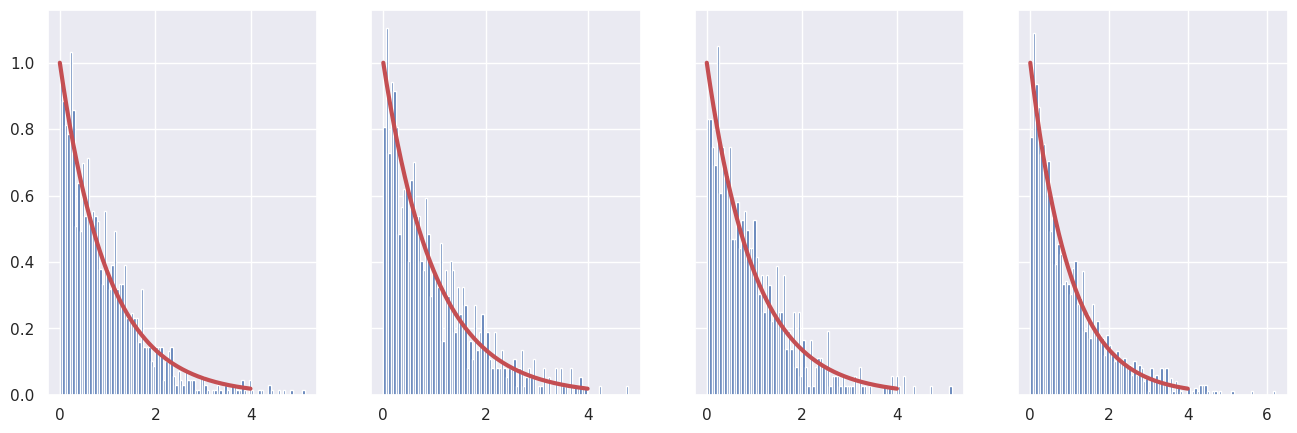

In [7]:
fig, axes = plt.subplots(1, layers, figsize=(16, 5), sharey=True)
for l in range(1, layers+1):
    s = sample[f's_{l}'][0]
    axes[l - 1].hist(s[s > 0], bins=100, density=True);
    x = jnp.arange(0, 4, 0.01)
    gamma = sample['gamma'][0, -l]
    axes[l - 1].plot(x, jnp.exp(- x), 'r', lw=3)

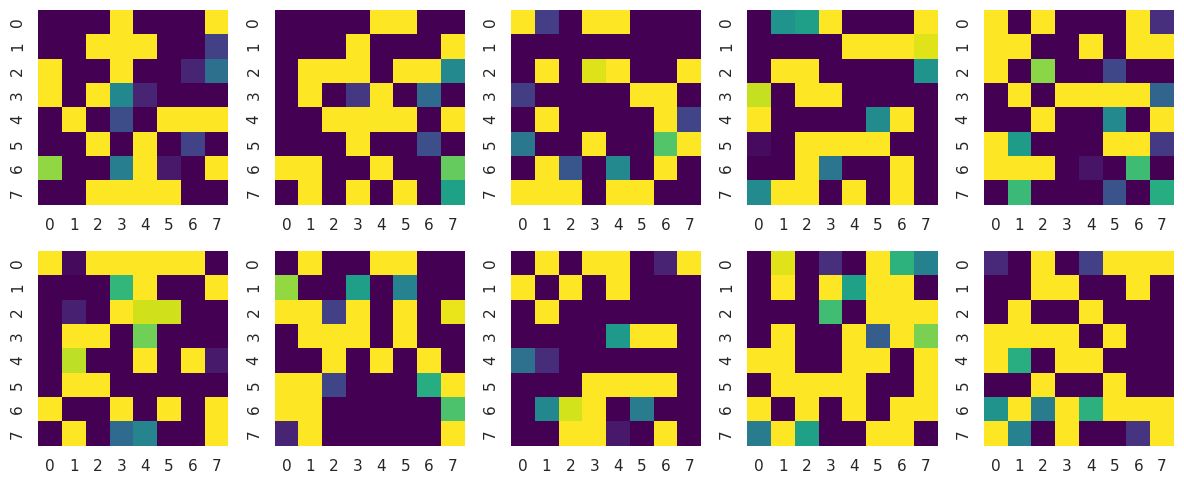

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

O = sample['v_0'][0]

for i, w in enumerate(O[:10]):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

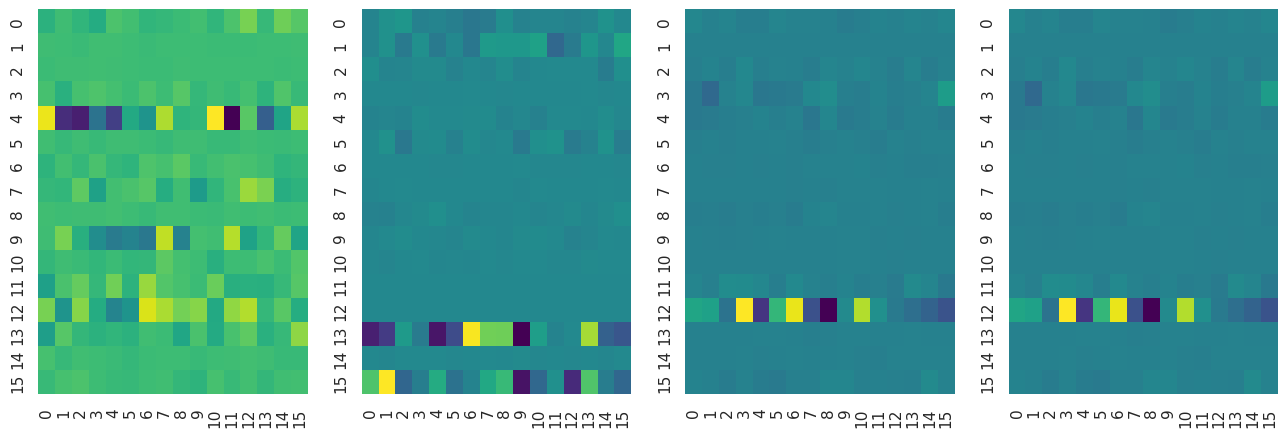

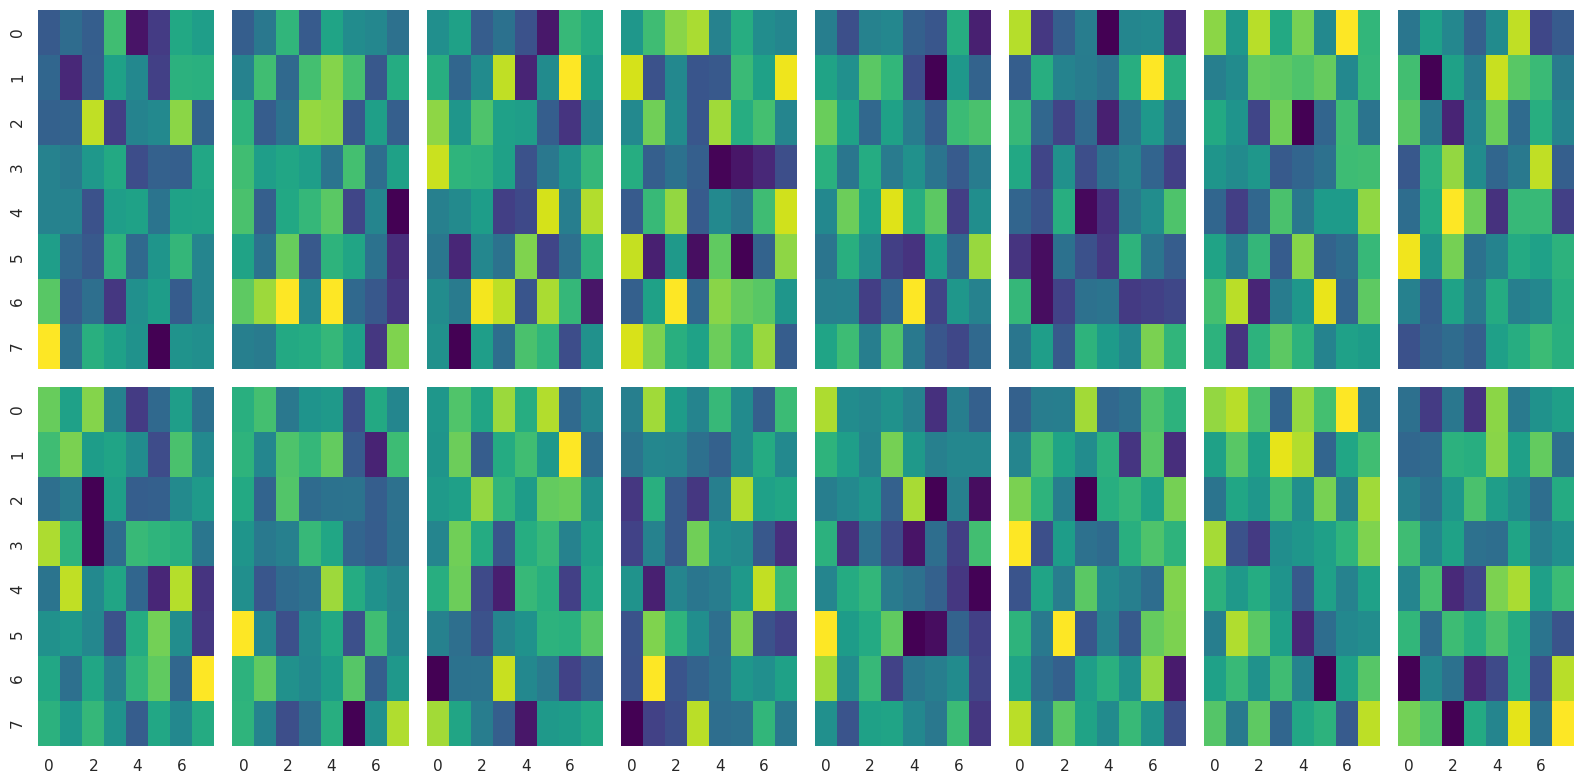

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, ax in enumerate(axes):
    sns.heatmap(sample['W'][0, i], ax=ax, cbar=False, cmap='viridis')

W1 = sample['W1'][0]

fig, axes = plt.subplots(2, 8, figsize=(16, 8), sharex=True, sharey=True)

for i, w in enumerate(W1):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, cmap='viridis')

fig.tight_layout()

In [10]:
cm = handlers.condition(model, data={'v_0': sample['v_0'][0]})
kernel = NUTS(cm)

mcmc = MCMC(kernel, num_warmup=900, num_samples=100)

rng_key, _rng_key = random.split(rng_key)
mcmc.warmup(_rng_key, collect_warmup=True, layers=5, d=32)
warm_smpl = mcmc.get_samples()
rng_key, _rng_key = random.split(rng_key)
mcmc.run(random.PRNGKey(0), layers=layers, d=32)

post_smpl = mcmc.get_samples()

sample: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s, 511 steps of size 8.27e-03. acc. prob=0.89]


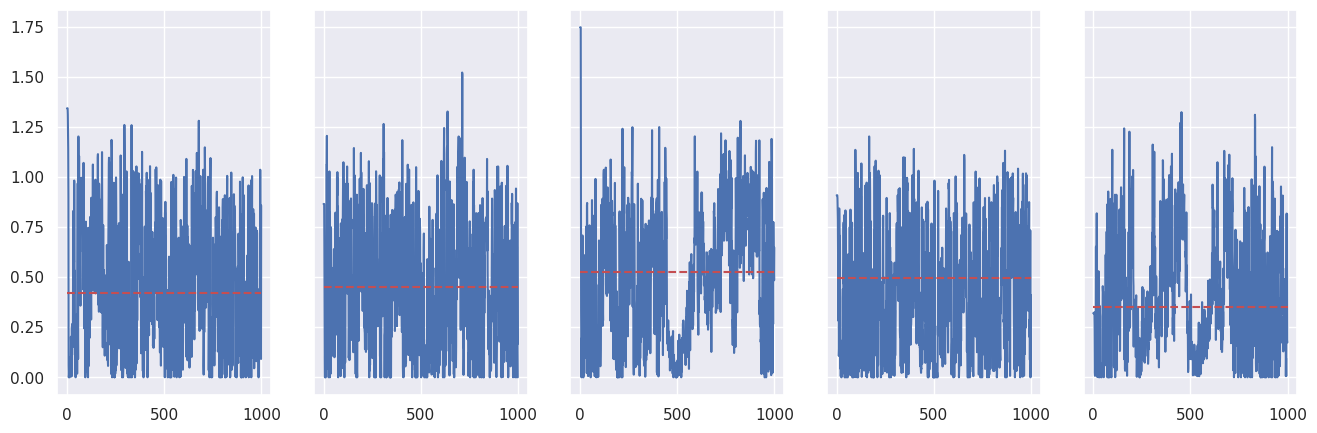

In [12]:
n = 0
pi = jnp.exp(- post_smpl['gamma']).mean(0)

fig, axes = plt.subplots(1, layers, figsize=(16, 5), sharex=True, sharey=True)

for l, ax in enumerate(axes):
    ax.plot( jnp.concatenate([warm_smpl[f's_{l+1}'][:, n].mean(-1), post_smpl[f's_{l+1}'][:, n].mean(-1)]) )
    ax.hlines(pi[ -l-1], 0, 1000, 'r', linestyle='--')

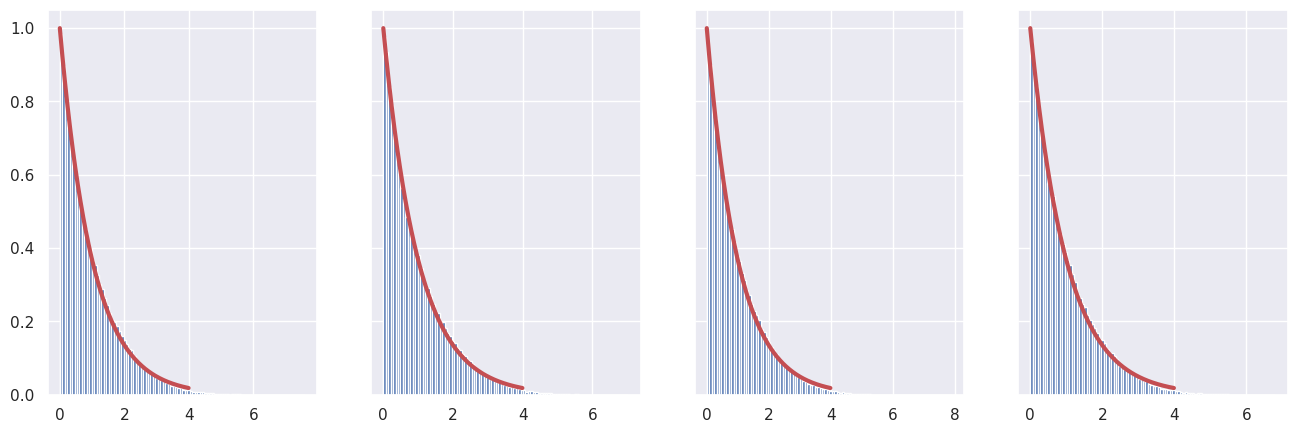

In [15]:
fig, axes = plt.subplots(1, layers, figsize=(16, 5), sharey=True)

for l in range(layers):
    axes[l].hist(post_smpl[f's_{layers - l}'][post_smpl[f's_{layers - l}'] > 0], bins=100, density=True);
    x = jnp.arange(0, 4, 0.01)
    axes[l].plot(x, jnp.exp(- x), 'r', lw=3)